Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using Tensorflow Similarity with Kaggle

[Google Landmark Retrieval 2021](https://www.kaggle.com/c/landmark-retrieval-2021/overview): Given an image, can you find all of the same landmarks in a dataset?

[TensorFlow Similarity](https://github.com/tensorflow/similarity) is a python package focused on making similarity learning quick and easy. 

## Notebook goal

This notebook demonstrates how to use TensorFlow Similarity to train a `SimilarityModel()` for a Kaggle competition and will. 

 1. Show how to efficiently load the Kaggle data from disk.
 
 1. `train()` a similarity model.

 2. `index()` the /index examples.

 3. `calibrate()` the model to estimate what is the best distance theshold to separate matching elements from elements belonging to other classes.

 5. Generate the submission file.

In [1]:
import csv
import os
import random
from collections import defaultdict
from multiprocessing import cpu_count
from pathlib import Path

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1
from tabulate import tabulate
from tqdm.auto import tqdm

In [3]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity -q
    import tensorflow_similarity as tfsim

In [4]:
from tensorflow_similarity.architectures import EfficientNetSim
from tensorflow_similarity.augmenters import RandAugment
from tensorflow_similarity.losses import MultiSimilarityLoss
from tensorflow_similarity.samplers import MultiShotMemorySampler
from tensorflow_similarity.visualization import confusion_matrix  # matching performance

In [5]:
tf.get_logger().setLevel("ERROR")  # silence TF warning
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # silence remaining TF warnings
tfsim.utils.tf_cap_memory()

In [6]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.6.0
TensorFlow Similarity 0.15.0.dev22


# Functions and variables

In [72]:
NUM_IMGS = 1580470
IMG_SIZE = 380  # based on the EfficientNet varient. Here we use 'B4'
LARGER_IMG_SIZE = int(IMG_SIZE * 1.4)  # Increased image size used for resize and crop.
CLASSES_PER_BATCH = 16  # batch size = CLASSES_PER_BATCH* 2
NUM_LANDMARKS = 203092
NUM_VAL_LANDMAKRS = 300

CPU_COUNT = cpu_count()
print("NUM CPU:", CPU_COUNT)

NUM CPU: 8


In [73]:
def plot_25(x, y):
    """Plot the first 25 images."""
    num_cols = num_rows = 5
    fig = plt.figure(figsize=(6.0, 6.0))
    grid = axes_grid1.ImageGrid(
        fig=fig,
        rect=111,
        nrows_ncols=(num_cols, num_rows),
        axes_pad=0.1,
    )

    for ax, im, label in zip(grid, x, y):
        max_val = float(tf.math.reduce_max(im))
        ax.imshow(im / max_val)
        ax.axis("off")

def load_img(img_path):
    "Load image from disk and resize it"
    img = tf.io.read_file(img_path, expand_animations = False)
    img = tf.io.decode_image(img)
    img = tf.keras.layers.Resizing(LARGER_IMG_SIZE, LARGER_IMG_SIZE)(img)
    img = tf.image.random_crop(img, (IMG_SIZE, IMG_SIZE, 3))
    img = tf.image.random_flip_left_right(img)
    return img

# Data preparation

The following section loads the test data into index and query splits as np.arrays. This will be used later to calibrate and test the model.

NOTE: these data sets are large and the following cells have been optimized to improve the loading speed.

In [74]:
data_path = Path("../../../kaggle_ds/google_landmarks")

# Sample a random set of landmark IDs for validation
val_lmk_idxs = random.sample(range(NUM_LANDMARKS), k=NUM_VAL_LANDMAKRS)

In [75]:
x_train_img_path, y_train = [], []
x_test_img_path, y_test = [], []
test_lndmrk_2id = {}

pb = tqdm(total=NUM_IMGS, desc="loading images path")

with open(data_path / "train.csv") as csvfile:
    # pathlib is slow while looping
    data_path_str = str(data_path)

    # reader is faster than DictReader
    reader = csv.reader(csvfile)
    next(reader)  # drop the header

    for row in reader:
        # compute path to img
        slug = [row[0][i] for i in range(3)]
        img_path = os.path.join(data_path_str, "train", *slug, f"{row[0]}.jpg")

        # add img either in validation or testing
        class_idx = int(row[1])
        if class_idx in val_lmk_idxs:
            y_test.append(class_idx)
            x_test_img_path.append(img_path)
            test_lndmrk_2id[class_idx] = len(test_lndmrk_2id)
        else:
            y_train.append(class_idx)
            x_train_img_path.append(img_path)
        pb.update()
pb.close()

print("train size", len(x_train_img_path))
print("test size", len(x_test_img_path))

loading images path:   0%|          | 0/1580470 [00:00<?, ?it/s]

train size 1578930
test size 1540


## Prepare Validation

In [76]:
# load validation image in memory
x_test = []
for img_path in tqdm(x_test_img_path):
    img = load_img(img_path)
    x_test.append(img)

x_test = np.array(x_test)
y_test = np.array(y_test)

  0%|          | 0/1540 [00:00<?, ?it/s]

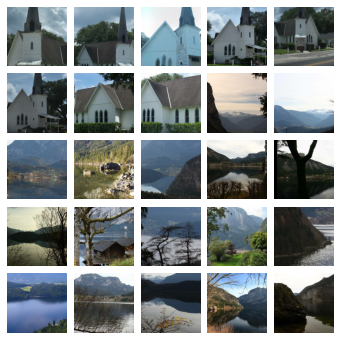

In [30]:
# Visualize the Validation Dataset
plot_25(x_test, y_test)

## Prepare training

The `Tensorflow Similarity` models expect a Dataset Sampler to ensure that each batch contains at least 2 examples of each class in the batch.

Here we are passing a `Callable` as the augmenter in the `MultiShotMemorySampler()`. This function will take in the image paths and then load, decode, reshape, crop, and apply a random augmentation. 

This enables us to load all the train image paths into memory, but only load a single batch of images at a time.

In [77]:
# read each image from disk and construct the batch as "augment function" to
# sampler
augmenter = tfsim.augmenters.RandAugment()


@tf.function()
def process(img):
    img = tf.io.decode_image(img, expand_animations = False)
    img = tf.keras.layers.Resizing(LARGER_IMG_SIZE, LARGER_IMG_SIZE)(img)
    img = tf.image.random_crop(img, (IMG_SIZE, IMG_SIZE, 3))
    img = tf.image.random_flip_left_right(img)
    return augmenter.distort(img)


def loader(x, y, *args):
    imgs = []
    for img_path in x:
        imgs.append(tf.io.read_file(img_path))
    imgs = tf.stack(imgs)
    imgs = tf.map_fn(process, imgs, parallel_iterations=cpu_count(), dtype="float32")
    return imgs, y

In [78]:
train_ds = MultiShotMemorySampler(
    x_train_img_path, y_train, classes_per_batch=CLASSES_PER_BATCH, augmenter=loader
)


The initial batch size is 32 (16 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/1578930 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/81201 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1578930 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1578930 [00:00<?, ?it/s]

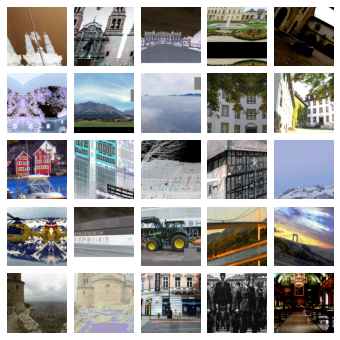

In [26]:
plot_25(*train_ds.generate_batch(0))

# Build and train

The following uses the EfficientNet as the backbone of the model and trains using `MutliSimilarityLoss()` for 10 epochs.

In [27]:
model = tfsim.architectures.EfficientNetSim(
    (IMG_SIZE, IMG_SIZE, 3),
    variant="B4",
    embedding_size=512,
    augmentation=None,
)
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 380, 380, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
metric_embedding (MetricEmbe (None, 512)               918016    
Total params: 18,591,839
Trainable params: 918,016
Non-trainable params: 17,673,823
_________________________________________________________________


In [28]:
loss = MultiSimilarityLoss(distance="cosine")
model.compile("adam", loss=loss)

Distance metric automatically set to cosine use the distance arg to override.


In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=10, restore_best_weights=True
)
history = model.fit(train_ds, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
1000/1000 [==============================] - 533s 517ms/step - loss: 1.0362 - val_loss: 1.5020
Warmup complete
Epoch 2/100
1000/1000 [==============================] - 511s 511ms/step - loss: 1.0227 - val_loss: 1.5165
Epoch 3/100
1000/1000 [==============================] - 510s 510ms/step - loss: 1.0154 - val_loss: 1.5242
Epoch 4/100
1000/1000 [==============================] - 507s 507ms/step - loss: 1.0145 - val_loss: 1.5290
Epoch 5/100
1000/1000 [==============================] - 508s 508ms/step - loss: 1.0127 - val_loss: 1.5287
Epoch 6/100
1000/1000 [==============================] - 508s 508ms/step - loss: 1.0131 - val_loss: 1.5411
Epoch 7/100
1000/1000 [==============================] - 506s 506ms/step - loss: 1.0079 - val_loss: 1.5731
Epoch 8/100
1000/1000 [==============================] - 510s 510ms/step - loss: 1.0068 - val_loss: 1.4814
Epoch 9/100
1000/1000 [==============================] - 506s 506ms/step - loss: 1.0088 - val_loss: 1.5090
Epoch 10/100
1000/100

In [31]:
model.save(data_path / "models_owen" / "B4_RandAug_512_v2")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = tf.keras.models.load_model(data_path / "models_owen" / "B4_RandAug_512_v2")

In [86]:
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 380, 380, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
metric_embedding_6 (MetricEm (None, 512)               918016    
Total params: 18,591,839
Trainable params: 918,016
Non-trainable params: 17,673,823
_________________________________________________________________


# Calibration

## Create Index and Query Splits

In [87]:
IMG_PER_CLASS = 10
index = defaultdict(list)
x_index, y_index = [], []
x_query, y_query = [], []

for idx in range(len(x_test)):
    class_idx = test_lndmrk_2id[y_test[idx]]
    img = x_test[idx]
    if len(index[class_idx]) < IMG_PER_CLASS:
        index[class_idx].append(img)
        x_index.append(img)
        y_index.append(class_idx)
    else:
        x_query.append(img)
        y_query.append(class_idx)


x_index = np.array(x_index)
y_index = np.array(y_index)
x_query = np.array(x_query)
y_query = np.array(y_query)

## Create Calibration Index

We can calibrate a distance threshold using a matching strategy and a calibration metric. Calibration requires creating an index, so here we load the x_index and y_index subset that we created when loading the training data.

In [88]:
model.reset_index()
model.index(x=x_index, y=y_index, data=x_index)

[Indexing 814 points]
|-Computing embeddings
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


## Find a Target Distance Threshold

Here we are searching for the optimal F1 score while using K=1 as our classifier. All matches at or below the calibrated threshold distance will be labeled as a Positive match between the query example and the label associated with the match result, while all matches above the threshold distance will be labeled as a Negative match.

Additionally, `model.calibrate()` returns a `CalibrationResults` object that can be used to plot and evaluate the metrics. The calibration object contains the following fields:

* "cutpoints": A Python dict mapping the cutpoint name to a dict containing the `ClassificationMetric` values associated with a particular distance threshold, e.g., "optimal" : {"acc": 0.90, "f1": 0.92}.
* "thresholds": A Python dict mapping `ClassificationMetric` names to a list containing the metric's value computed at each of the distance thresholds, e.g., {"f1": [0.99, 0.80], "distance": [0.0, 1.0]}.

In [89]:
# B4 v2
calibration = model.calibrate(x_query, y_query)


Performing NN search



Building NN list:   0%|          | 0/726 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/726 [00:00<?, ?it/s]


 name       value    distance    precision    recall        f1
-------  -------  ----------  -----------  --------  --------
optimal     0.85   0.0934756     0.741047         1  0.851266


In [90]:
# B4 v2
class_counts = {l: c for l, c in zip(*np.unique(y_index, return_counts=True))}
map10 = tfsim.retrieval_metrics.MapAtK(r=class_counts, k=10)
_ = model.evaluate_retrieval(x_query, y_query, retrieval_metrics=[map10])

|-Computing embeddings
|-Computing retrieval metrics

Performing NN search



Building NN list:   0%|          | 0/726 [00:00<?, ?it/s]


 [Summary]

metric       Value
--------  --------
map@10    0.393764


## Metrics Plots

The following plots show the change in the classification metrics over as the distance changes.

AttributeError: 'dict' object has no attribute 'thresholds'

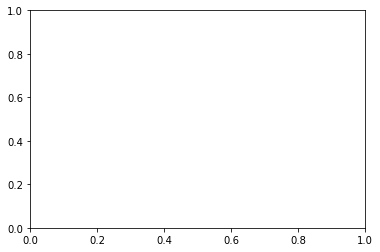

In [46]:
fig, ax = plt.subplots()
x = calibration.thresholds["distance"]
ax.plot(x, calibration.thresholds["f1"], label="f1")
ax.plot(x, calibration.thresholds["precision"], label="precision")
ax.plot(x, calibration.thresholds["recall"], label="recall")
ax.set_xlabel("Distance")
ax.legend()
plt.show()

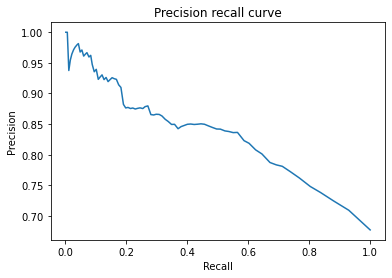

In [40]:
fig, ax = plt.subplots()
ax.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax.set_title("Precision recall curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
plt.show()

# Submission Code

## Index Data

We need to create the index in order to create the submission file. Tensorflow similarity enables users to batch add the index examples using the `model.index()` method. 

The following cell loads the index dataset img paths and then constructs batches of images and image IDs.

In [14]:
BATCH_SIZE = 256
test_path = data_path / "index"
index_imgs_path = list(test_path.glob("**/*.jpg"))
total_imgs = len(index_imgs_path)
# total_imgs = 1000  # remove to index the whole dataset 70k images

# reset the index
model.reset_index()

# indexing
pb = tqdm(total=total_imgs, desc="indexing images")
for idx in range(0, total_imgs, BATCH_SIZE):
    imgs = []
    img_ids = []

    # construct the batch
    for i in range(idx, min(idx + BATCH_SIZE, total_imgs)):
        img_path = index_imgs_path[i]
        imgs.append(load_img(str(img_path)))
        img_ids.append(img_path.stem)
        pb.update()
        
    if total_imgs - (idx+1) <= BATCH_SIZE:
        build = True

    # add the batch to the index
    model.index(np.array(imgs), data=img_ids, build=build, verbose=0)
pb.close()

indexing images:   0%|          | 0/76176 [00:00<?, ?it/s]

IndexError: list index out of range

## Match Test Images

Next we need to find the K nearest neighbors in the index for each image in the test dataset. The competition asks for the 100 nearest neighbors, but here we return the 10 nearest to keep the example simple.

Each query returns a list of `Lookup` object. For each list, we unpack the image ID stored in the `Lookup.data` field and then map the query image ID to the set of `Lookup` image IDs.

In [21]:
BATCH_SIZE = 64
k = 100  # competition assume k == 100 - using 10 for demo purpose.
results = defaultdict(list)
test_path = data_path / "test"
test_imgs_path = list(test_path.glob("**/*.jpg"))
total_imgs = len(test_imgs_path)
# total_imgs = 1000  # remove to index the whole dataset 70k images

# indexing
pb = tqdm(total=total_imgs, desc="matching images")
for idx in range(0, total_imgs, BATCH_SIZE):
    query_imgs = []
    query_img_ids = []

    # construct the batch
    for i in range(idx, min(idx + BATCH_SIZE, total_imgs)):
        img_path = test_imgs_path[i]
        query_imgs.append(load_img(str(img_path)))
        query_img_ids.append(img_path.stem)
        pb.update()

    # retrieve the KNN
    match_sets = model.lookup(np.array(query_imgs), verbose=0)

    # map the query image ID to the set of neighbor img IDs
    for query_img_id, match_set in zip(query_img_ids, match_sets):
        results[query_img_id] = [lookup.data for lookup in match_set]
pb.close()

matching images:   0%|          | 0/1129 [00:00<?, ?it/s]

## Check Data

The competition requires the data to be a two column CSV consisting of the query image ID and a space separated string representing the matching image IDs.

Here we print out the first 10 rows and verify the formatting.

In [22]:
rows = [[k, " ".join(v)] for k, v in results.items()]
print(tabulate(rows[:10], headers=["id", "images"], tablefmt="csv"))

id                images
----------------  ------------------------------------------------------------------------------------
8890929c27318d2b  300a62c4aa015b22 d85b4f2cf7b12cec b0602258b90a5e39 9f0b1b1eab40e062 1b478d6430674605
88ec81deb52a3df6  680fbbc181a7c2a8 33231d63685b9174 cdcec70c2727f7c8 985be0215cee945d 9d8559f72f4e7194
88471a39dac8ac43  bf7db1057fdee4df 482945f3b0d9f9e5 d2f0544c9c835cd1 94d4d33077703076 4f872c99b19ce1d0
88c00cecf7a76f74  a1c1a51d48b36152 02466f041e560dcc fcd456bb1f95b00a 8024788bbe87c72a eb3591d979728e9b
8821cb4b5330b189  59ca927b6e0c8a7a e027bb05b42425f1 39346bbb0908d063 ac73dba0d1478f0e 871885fa7b96ee72
8982b9bdab72d897  0abcae3d89059199 9a8c382fa43a3edd 1646d3c5bd59afa7 442f6d6d1373e8b5 ecba0f3f909420cf
89b12ae28e5f957a  72d951db7bd76d39 1b3522c7e7e7b4f7 9563c2f29fd2cab1 1b5b5a04c482fa9f f7a39778927c766f
8380babca9f46d53  5c9cae28694de262 39c00028b36c6d74 12a0c74f231dd1c7 84514415a1d25160 b76043e0cb228161
83f2225112c40910  df921f88a7b15dcd dd867e4962e7f

## Write Submission File

Finally, we write the results to disk.

In [23]:
with open(data_path / "submission.csv", "w+", newline="", encoding="utf-8") as out:
    writer = csv.writer(out)
    writer.writerow(["id", "images"])
    writer.writerows(rows)